# Split one COCO annotation JSON file into training and validation JSON files.

Given a single COCO annotated JSON file, your goal is to split them into training and validation COCO annotated JSON files.

 A single JSON file needs to be split into training and validation files. The output files will be further converted to TFRecord files using another notebook.

This notebook uses a third party library to accomplish this task. The library can split the JSON files according to the ratio. We kept the validation file to contain 20% of the data. 

This notebook is an end to end example. When you run the notebook, it will take one JSON file and will split into a train and a val JSON file.

**Note** - In this example, we assume that all our data is saved on Google drive and we will also write our outputs to Google drive. We also assume that the script will be used as a Google Colab notebook. But this can be changed according to the needs of users. They can modify this in case they are working on their local workstation, remote server or any other database. This colab notebook can be changed to a regular jupyter notebook running on a local machine according to the need of the users.

## **MUST DO** - Install and restart runtime

In [ ]:
# install python object detection insights library to merge multiple COCO annotation files
!pip install pyodi

# RESTART THE RUNTIME in order to use this library

## Run the below command to connect to your google drive

In [ ]:
# import other libraries
from google.colab import drive
import pyodi
import subprocess
import sys
import os
import json
import numpy as np
import pandas as pd

In [ ]:
# connect to google drive
drive.mount('/content/gdrive')

# making an alias for the root path
try:
  !ln -s /content/gdrive/My\ Drive/ /mydrive
  print('Successful')
except Exception as e:
  print(e)
  print('Not successful')

Mounted at /content/gdrive
Successful


## Visualization function

In [ ]:
def data_creation(path: str) -> pd.DataFrame:
  """Create a dataframe with the occurences of images and categories.
  Args:
    path: path to the annotated JSON file.
  Returns:
    dataset consisting of the counts of images and categories.
  """
  # get annotation file data into a variable
  with open(path) as json_file:
    data = json.load(json_file)

  # count the occurance of each category and an image in the annotation file
  category_names = [i['name'] for i in data['categories']]
  category_ids = [i['category_id'] for i in data['annotations']]
  image_ids = [i['image_id'] for i in data['annotations']]

  # create a dataframe
  df = pd.DataFrame(
      list(zip(category_ids, image_ids)), columns=['category_ids', 'image_ids'])
  df = df.groupby('category_ids').agg(
      object_count=('category_ids', 'count'),
      image_count=('image_ids', 'nunique'))
  df = df.reindex(range(1, len(data['categories']) + 1), fill_value=0)
  df.index = category_names
  return df

def visualize_detailed_counts_horizontally(path: str) -> None:
  """Plot a vertical bar graph showing the counts of images & categories.
  Args:
    path: path to the annotated JSON file.
  """
  df = data_creation(path)
  ax = df.plot(
      kind='bar',
      figsize=(40, 10),
      xlabel='Categories',
      ylabel='Counts',
      width=0.8,
      linewidth=1,
      edgecolor='white')  # rot = 0 for horizontal labeling
  for p in ax.patches:
    ax.annotate(
        text=np.round(p.get_height()),
        xy=(p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='top',
        xytext=(4, 14),
        textcoords='offset points')

## Define the paths of inputs and outputs

In [ ]:
input_file = '/mydrive/TFHub/jsons/merged.json' #@param {type:"string"}
output_folder = '/mydrive/TFHub/jsons/' #@param {type:"string"}

## Split coco annotation file into train and val COCO files

In [ ]:
# split a COCO annotation file into train and val files
!pyodi coco random-split $input_file $output_folder --val-percentage 0.2

# there will be two files with name '_train.json' and '_val.json' in the output_folder

2022-09-09 21:40:00.173 | INFO     | pyodi.apps.coco.coco_split:random_split:183 - Gathering images...
2022-09-09 21:40:00.192 | INFO     | pyodi.apps.coco.coco_split:random_split:194 - Gathering annotations...
2022-09-09 21:40:11.078 | INFO     | pyodi.apps.coco.coco_split:random_split:218 - Saving splits to file...
/mydrive/TFHub/jsons/_train.json
/mydrive/TFHub/jsons/_val.json


## Visualization

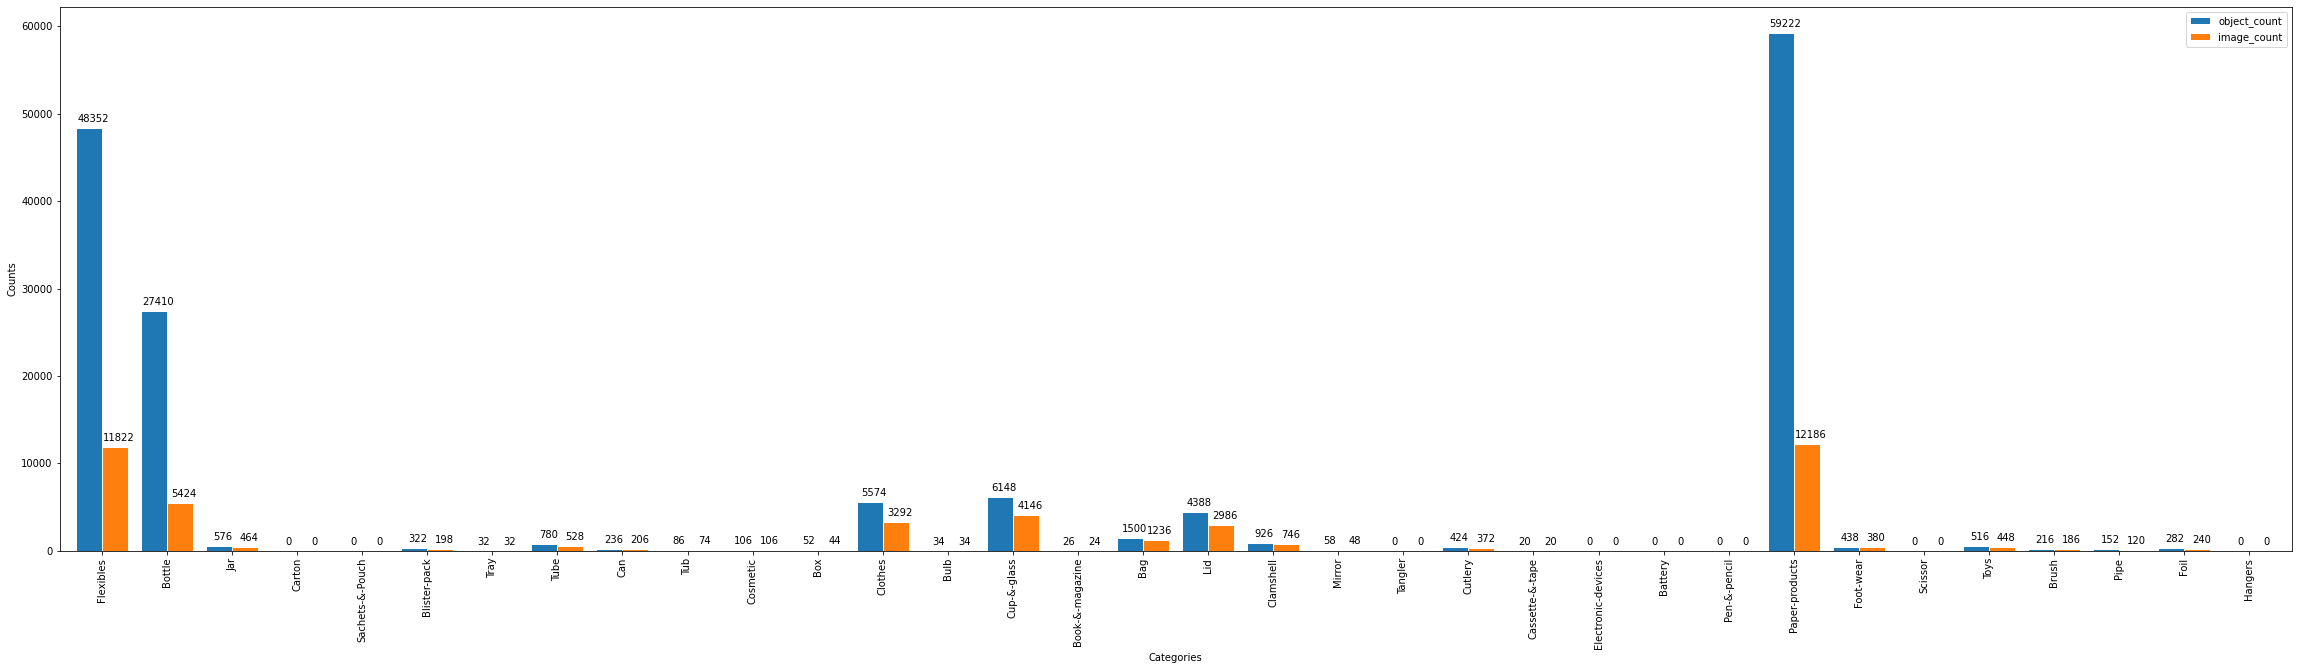

In [ ]:
# visualization of the input COCO annotated JSON file
visualize_detailed_counts_horizontally(input_file)

Train JSON
Validation JSON


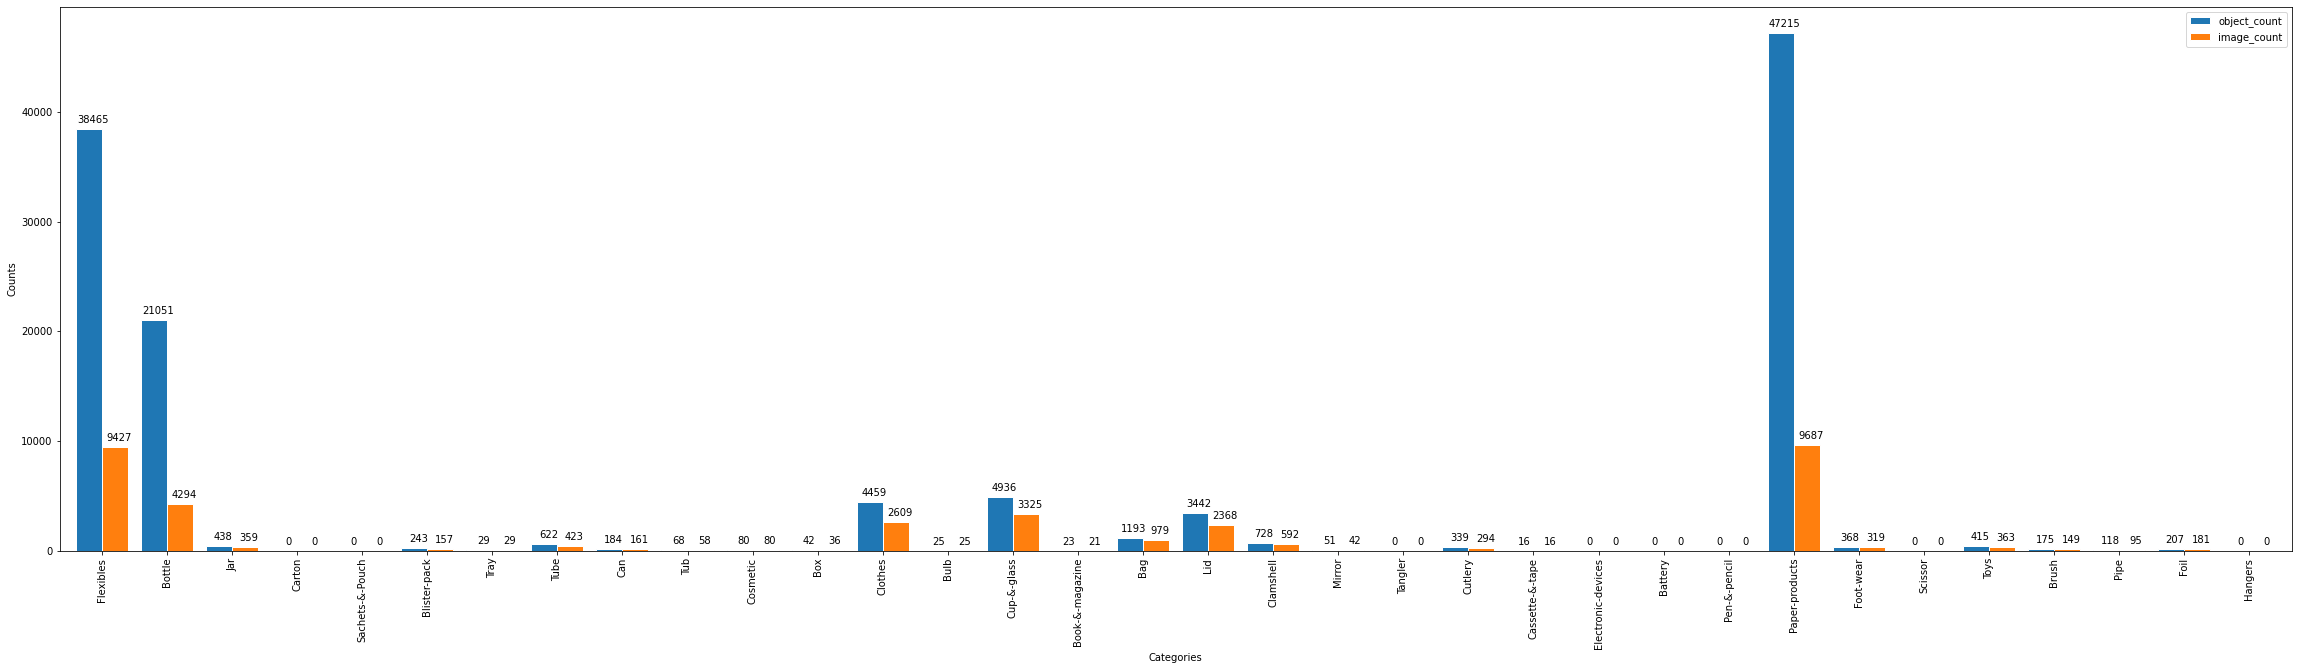

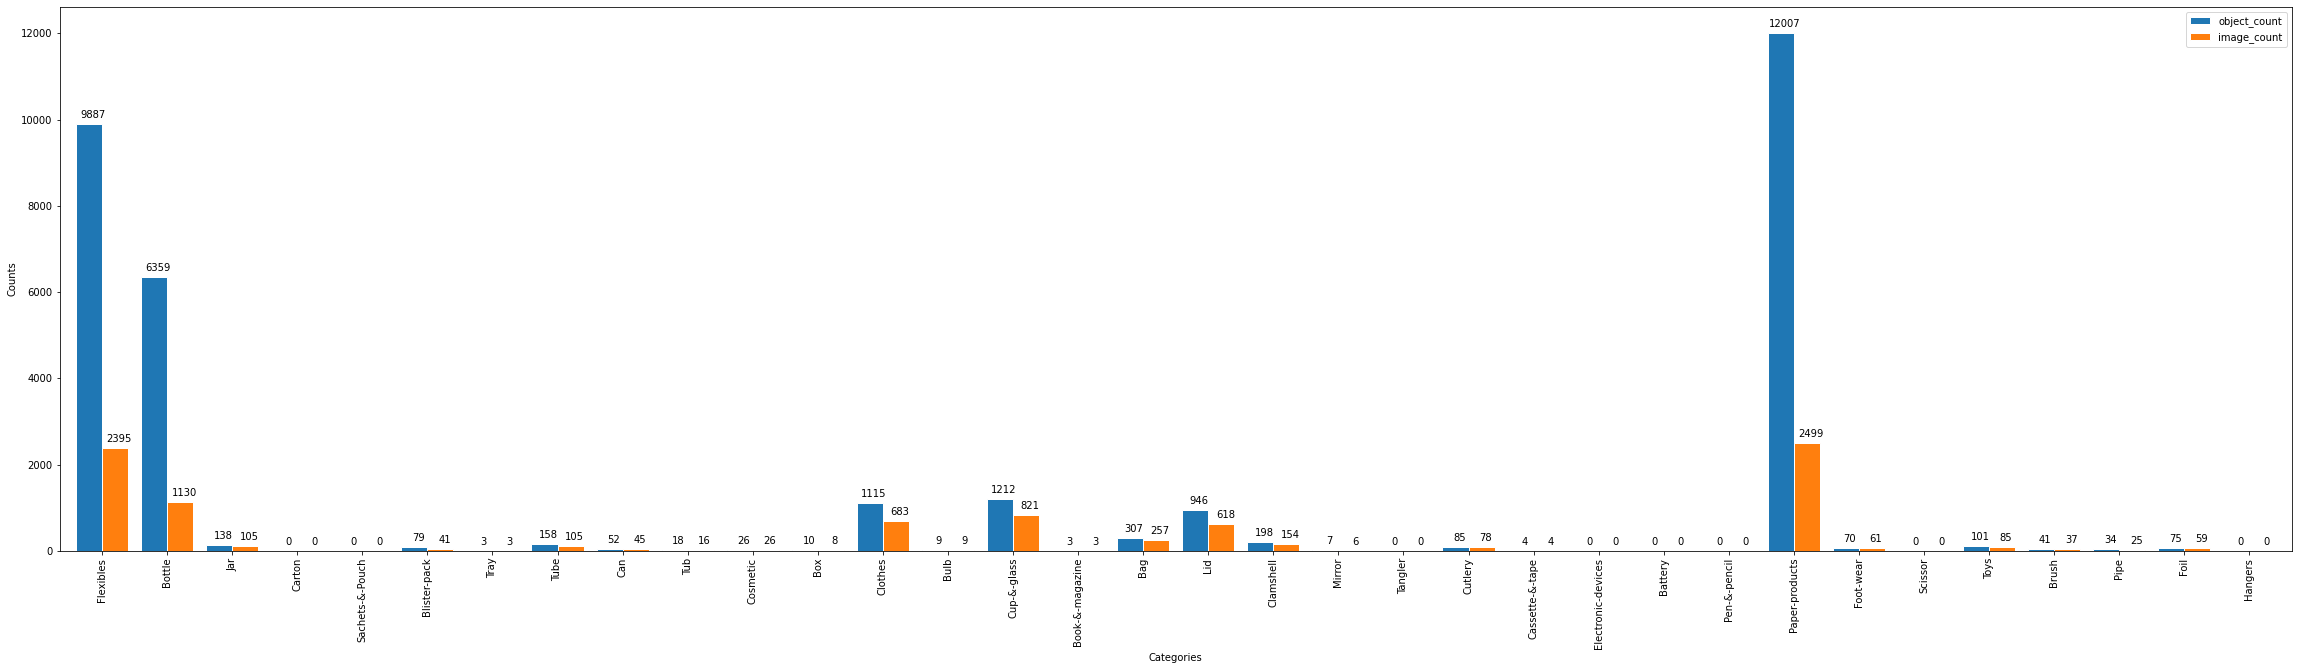

In [ ]:
# visualization of the training COCO annotated JSON file
print('Train JSON')
visualize_detailed_counts_horizontally(output_folder + '_train.json')

print('Validation JSON')
# visualization of the validation COCO annotated JSON file
visualize_detailed_counts_horizontally(output_folder + '_val.json')